# Preparation of Data

In [1]:
import fitsio as ft
import healpy as hp
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.utils import hpix2radec, split_jackknife_strip

%matplotlib inline
import matplotlib.pyplot as plt

Read appropriate columns

In [3]:
# read imaging
dt = pd.read_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5')
dr8_cols = ['ebv', 'loghi', 'nstar',
            'depth_r_total', 'depth_g_total', 'depth_z_total',
             'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',
            'airmass_r_mean', 'airmass_g_mean', 'airmass_z_mean',
            'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
             'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
             'mjd_r_min', 'mjd_g_min', 'mjd_z_min', 
            'galdepth_g','galdepth_r', 'galdepth_z', 
            'psfsize_g', 'psfsize_r', 'psfsize_z']
features = dt[dr8_cols].values


# read data and randoms
ngal = hp.read_map('/home/mehdi/data/tanveer/elg_gal256.fits', verbose=False, dtype=np.float64)
nran = hp.read_map('/home/mehdi/data/tanveer/elg_ran256.fits', verbose=False, dtype=np.float64)
frac = nran / nran[nran > 0].mean()

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


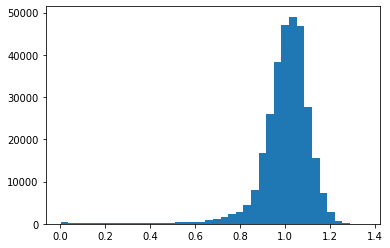

In [4]:
_ = plt.hist(frac[nran>0], bins=40)

In [7]:
mask = frac > 0.2
npix = mask.sum()
nsys = features.shape[1]
print(f'npix: {npix}, nsys: {nsys}')
isgood = np.isfinite(features).sum(axis=1) == nsys
mask = mask & isgood
npix = mask.sum()
print(f'npix: {npix}, nsys: {nsys}')

npix: 302795, nsys: 27
npix: 302503, nsys: 27


In [8]:
data = np.zeros(npix, dtype=[('label', 'f8'),
                             ('features', 'f8', nsys),
                             ('hpix', 'i8'),
                             ('fracgood', 'f8')])

data['label'] = ngal[mask]
data['fracgood'] = frac[mask]
data['features'] = features[mask, :]
data['hpix'] = np.argwhere(mask).flatten()
ft.write('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits', data, clobber=True)

In [10]:
for ni in data.dtype.names:
    print((~np.isfinite(data[ni])).sum(), ni)

0 label
0 features
0 hpix
0 fracgood


In [11]:
for i in range(data['features'].shape[1]):
    print(np.std(data['features'][:, i]), i)

0.0324522365999097 0
0.24676607647539517 1
550.9678470423167 2
0.5453596961046706 3
0.460072950968793 4
0.3398449458209416 5
0.4861657472377818 6
0.4330989076953627 7
0.2951514697330035 8
0.2735265257649082 9
0.2676904587698299 10
0.29974618479927223 11
0.5325523954193835 12
0.44819525802087906 13
0.32808173722527234 14
9030.468845016689 15
10422.278171963622 16
19097.314448930163 17
548.7131457853025 18
505.768741111331 19
475.1770182805158 20
0.26292189723357745 21
0.3651981766127112 22
0.1942551042540837 23
0.26579899443464733 24
0.2388452860229008 25
0.17912486892118784 26


# Jackknife prep

In [5]:
data = ft.read('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits')

njack = 25
indices_raw = np.arange(data['hpix'].size)
chunks = split_jackknife_strip(indices_raw, data['fracgood'], njack=njack)


for i, chunk in enumerate(chunks[0]):
    print(i, np.sum(data['fracgood'][chunk]))
    if i > 5:break
        
        
jkindices = []
for i in range(len(chunks[0])):
    indices_ = chunks[0].copy()
    indices_.pop(i)
    jkindices.append(np.concatenate(indices_))         

0 12160.160191454803
1 12160.829932540815
2 12160.262912480264
3 12160.41493959795
4 12161.002503863594
5 12161.027156909702
6 12160.406721915911


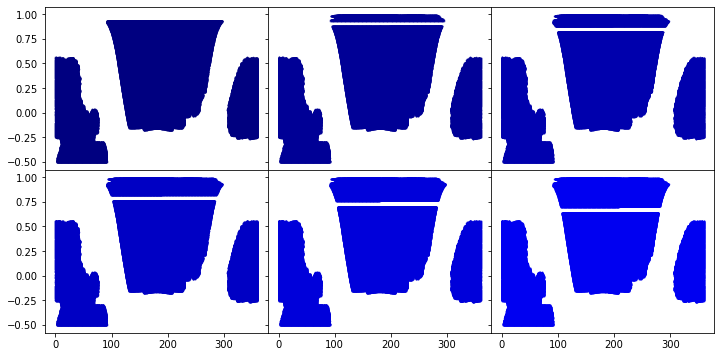

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=2, 
                       figsize=(12, 6), 
                       sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
ax = ax.flatten()

for i, jack in enumerate(jkindices):
    
    myhpix = data['hpix'][jack]
    ra, dec = hpix2radec(256, myhpix)
    
    ax[i].scatter(ra, np.sin(np.deg2rad(dec)), 1, alpha=0.4, color=plt.cm.jet(i/50))
    if i > 4:break

In [12]:
#!mkdir -p /home/mehdi/data/tanveer/jackknife/25/   # create the dir

In [15]:
for i, jack in enumerate(jkindices):  
    mydata = data[jack]
    ft.write(f'/home/mehdi/data/tanveer/jackknife/25/dr8jk{i}_elg_0.32.0_256.fits', mydata, clobber=True)

In [16]:
ls /home/mehdi/data/tanveer/jackknife/25/

dr8jk0_elg_0.32.0_256.fits   dr8jk21_elg_0.32.0_256.fits
dr8jk10_elg_0.32.0_256.fits  dr8jk22_elg_0.32.0_256.fits
dr8jk11_elg_0.32.0_256.fits  dr8jk23_elg_0.32.0_256.fits
dr8jk12_elg_0.32.0_256.fits  dr8jk24_elg_0.32.0_256.fits
dr8jk13_elg_0.32.0_256.fits  dr8jk2_elg_0.32.0_256.fits
dr8jk14_elg_0.32.0_256.fits  dr8jk3_elg_0.32.0_256.fits
dr8jk15_elg_0.32.0_256.fits  dr8jk4_elg_0.32.0_256.fits
dr8jk16_elg_0.32.0_256.fits  dr8jk5_elg_0.32.0_256.fits
dr8jk17_elg_0.32.0_256.fits  dr8jk6_elg_0.32.0_256.fits
dr8jk18_elg_0.32.0_256.fits  dr8jk7_elg_0.32.0_256.fits
dr8jk19_elg_0.32.0_256.fits  dr8jk8_elg_0.32.0_256.fits
dr8jk1_elg_0.32.0_256.fits   dr8jk9_elg_0.32.0_256.fits
dr8jk20_elg_0.32.0_256.fits


# 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
import fitsio as ft

import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.utils import hpixsum, make_overdensity, hpix2radec
from lssutils.stats.cl import AnaFast
from lssutils.stats.nnbar import MeanDensity

In [2]:
class GenSys:
    
    def __init__(self, weightfile, nside=256):        
        
        self.npred_ = ft.read(weightfile)
        self.mask = np.zeros(12*nside*nside, '?')
        self.mask[self.npred_['hpix']] = True
        self.shape = self.npred_['weight'].shape
        
        print('# of selection functions: ', self.shape)
        
    def fetch_npred(self, ix):
        
        npred = np.zeros(self.mask.size)
        if len(self.shape) > 1:
            wnn_ix = 1.*self.npred_['weight'][:, ix]
        else:
            wnn_ix = 1.*self.npred_['weight']
        
        wnn_ix = wnn_ix / wnn_ix.mean()
        wnn_ix = wnn_ix.clip(0.5, 2.0)        
        npred[self.npred_['hpix']] = wnn_ix
        
        return npred
        

    def __call__(self, ix, mask, delta):
        #
        npred = self.fetch_npred(ix)

        mask_comm = mask & self.mask
        #norm_fact = dat[mask_comm].sum()/(dat[mask_comm]*npred[mask_comm]).sum()
        #norm_fact = np.std(delta[mask_comm])/np.std(delta[mask_comm]*npred[mask_comm])
        #npred *= norm_fact
        
        
        delta_cont = delta.copy()
        delta_cont[mask_comm] = delta_cont[mask_comm]*npred[mask_comm] + (npred[mask_comm]-1.0)
        
        return delta_cont

# Jackknife

In [3]:
def main(path_selection_function, do_default=False):
    
    
    gensys = GenSys(path_selection_function)
        
    dat_ = ft.read('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_10.fits')    
    dat = hpixsum(256, dat_['RA'], dat_['DEC'])*1.0
    ran = hp.read_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits', 
                      verbose=False, dtype=np.float64)*1.0
    mask = (ran > 0) & (gensys.mask)
    delta_clean = make_overdensity(dat, ran, mask) # clean delta


    af = AnaFast()

    cl_bef = af(delta_clean, ran, mask)
    cl_aft = []

    for ix in range(125):
        delta_ix = gensys(ix, mask, delta_clean)
        cl_aft_ = af(delta_ix, ran, mask)    
        cl_aft.append(cl_aft_['cl'])
        print('.', end='')
    cl_aft = np.array(cl_aft)    

    # cell of the selection functions
    cl_sf = []
    for ix in range(125):
        npred = gensys.fetch_npred(ix)
        delta_ = make_overdensity(npred, ran, mask)
        cl_sf.append(af(delta_, ran, mask)['cl'])
        print('.',end='')    
    cl_sf = np.array(cl_sf)
    return cl_bef, cl_aft, cl_sf

In [4]:
cl_bef_jk, cl_aft_jk, cl_sf_jk = main('/home/mehdi/data/tanveer/elg_mse_jk/nn-weights-combined.fits')

# of selection functions:  (302503, 125)
..........................................................................................................................................................................................................................................................

In [5]:
cl_bef_ri, cl_aft_ri, cl_sf_ri = main('/home/mehdi/data/tanveer/elg_mse/nn-weights-combined.fits')
cl_bef_se, cl_aft_se, cl_sf_se = main('/home/mehdi/data/tanveer/elg_mse_snapshots/nn-weights-combined.fits')

# of selection functions:  (302503, 125)
..........................................................................................................................................................................................................................................................# of selection functions:  (302503, 125)
..........................................................................................................................................................................................................................................................

In [8]:
plt.rc('font', size=15)

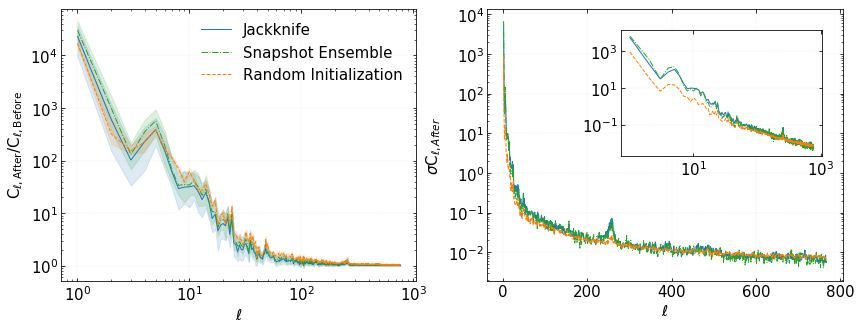

In [9]:
def add_plot(ax, cl_aft, cl_bef, color, ls, label):
    # plot Cl before and after
    ell = np.arange(1, 768)    
    cl_aft_m = np.mean(cl_aft, axis=0)
    
    ax.plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], color=color, ls=ls, lw=1, label=label)
    ax.fill_between(ell, *np.percentile(cl_aft[:, 1:]/cl_bef['cl'][1:], [0, 100], axis=0),
                    color=color, alpha=0.15)
    
    return ax

def add_plot2(ax, cl_aft, cl_bef, color, ls, label):
    # plot Cl before and after
    ell = np.arange(1, 768)    
    
    ax.plot(ell, np.std(cl_aft[:, 1:], axis=0)/cl_bef['cl'][1:], color=color, ls=ls, lw=1, label=label)    
    return ax
    
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(14, 5))

add_plot(ax, cl_aft_jk, cl_bef_jk, 'C0', '-', 'Jackknife')
add_plot(ax, cl_aft_se, cl_bef_se, 'C2', '-.', 'Snapshot Ensemble')
add_plot(ax, cl_aft_ri, cl_bef_ri, 'C1', '--', 'Random Initialization')

add_plot2(ax1, cl_aft_jk, cl_bef_jk, 'C0', '-', 'Jackknife')
add_plot2(ax1, cl_aft_se, cl_bef_se, 'C2', '-.', 'Snapshot Ensemble')
add_plot2(ax1, cl_aft_ri, cl_bef_ri, 'C1', '--', 'Random Initialization')


ax2 = fig.add_axes([0.68, 0.47, 0.2, 0.35])
add_plot2(ax2, cl_aft_jk, cl_bef_jk, 'C0', '-', 'Jackknife')
add_plot2(ax2, cl_aft_se, cl_bef_se, 'C2', '-.', 'Snapshot Ensemble')
add_plot2(ax2, cl_aft_ri, cl_bef_ri, 'C1', '--', 'Random Initialization')


ax2.set(yscale='log', xscale='log')
#ax2.set(xlim=(195, 295), ylim=(0.8, 1.6))

# for cl_aft_ in cl_aft:
#     ax.plot(ell, cl_aft_[1:], 'k-', alpha=0.2, lw=1, zorder=-1)
#ax.legend(['Before', 'Mean After', 'After'])
ax.set(yscale='log', xscale='log', 
       ylabel=r'C$_{\ell, \rm After}$/C$_{\ell, \rm Before}$', 
       xlabel=r'$\ell$')
ax.set(yscale='log', xscale='log', 
       ylabel=r'C$_{\ell, \rm After}$/C$_{\ell, \rm Before}$', 
       xlabel=r'$\ell$')

ax1.set(yscale='log', 
       ylabel=r'$\sigma$C$_{\ell, After}$', 
       xlabel=r'$\ell$')

for axi in [ax, ax1, ax2]:
    axi.tick_params(direction='in', which='both', axis='both', top=True, right=True)
    axi.grid(True, ls=':', lw=0.2)
ax.legend(frameon=False, 
          fontsize=15)

# fig.savefig('./cl_std.png', dpi=300, bbox_inches='tight')

In [10]:
from lssutils.utils import histogram_cell

(125, 7)
(125, 7)
(125, 7)


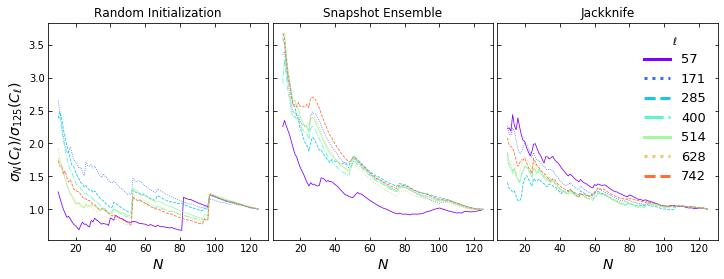

In [207]:
def add_plot(ax, cl_aft, legend=False):
    #np.random.seed(42)
    #shuff = np.random.choice(np.arange(cl_aft_.shape[0]), replace=False, size=cl_aft_.shape[0])
    #cl_aft = cl_aft_[shuff, :]*1.0    
    # std_all = np.std(cl_aft, axis=0)#/np.sqrt(125.)

    # nmocks = np.arange(10, 125, 10)#[::-1]

    # for i, nmock in enumerate(nmocks):
    #     std_b = np.std(cl_aft[:nmock, :], axis=0)#/np.sqrt(nmock)
    #     m = ax.plot(std_b/std_all,
    #                  color=plt.cm.jet(i/len(nmocks)), lw=0.3, label='%d'%nmock)
    
    cl_aft_b = []
    for i in range(cl_aft.shape[0]):
        elb, clb = histogram_cell(cl_aft[i, :], bins=np.linspace(0, 800, endpoint=True, num=8))
        cl_aft_b.append(clb)
    cl_aft_b = np.array(cl_aft_b)
    print(cl_aft_b.shape)
    
    
    ls = 10*['-', ':', '--', '-.']
    std_all = np.std(cl_aft_b, axis=0)
    #ells = [10, 20, 30, 50, 100, 200, 500, 700]
    nmocks = np.arange(10, 126)    
    
    for i, ell in enumerate(elb):
        std_list = []
        for j, nmock in enumerate(nmocks):
            std_list.append(np.std(cl_aft_b[:nmock, i], axis=0))
        ax.plot(nmocks, std_list/std_all[i]*np.sqrt(125./nmocks), lw=0.8, ls=ls[i],
                color=plt.cm.rainbow(i/len(elb)), label='%d'%ell)        
        
    if legend:
        leg = ax.legend(frameon=False,
                        fontsize=13, title=r'$\ell$')    
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

        
    

fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.02)


add_plot(ax[0], cl_aft_ri, False)
add_plot(ax[1], cl_aft_se, False)
add_plot(ax[2], cl_aft_jk, True)

for i, name in enumerate(['Random Initialization', 'Snapshot Ensemble', 'Jackknife']):
    #ax[i].text(0.1, 0.1, name, transform=ax[i].transAxes)
    ax[i].set_title(name)
       
for i, ax_ in enumerate(ax):
    if i==0:
        ax_.set_ylabel(r'$\sigma_{N} (C_{\ell})/\sigma_{125} (C_{\ell})$', fontsize=14)
    ax_.set_xlabel(r'$N$', fontsize=14)
    ax_.tick_params(direction='in', which='both', axis='both', right=True, top=True)
    
fig.savefig('std_cl_ensemble_size.png', dpi=300, bbox_inches='tight')    

In [210]:
import pandas as pd
import healpy as hp

In [211]:
dt = pd.read_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5')
dr8_cols = ['ebv', 'loghi', 'nstar',
            'depth_r_total', 'depth_g_total', 'depth_z_total',
             'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',
            'airmass_r_mean', 'airmass_g_mean', 'airmass_z_mean',
            'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
             'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
             'mjd_r_min', 'mjd_g_min', 'mjd_z_min', 
            'galdepth_g','galdepth_r', 'galdepth_z', 
            'psfsize_g', 'psfsize_r', 'psfsize_z']
features = dt[dr8_cols].values

In [212]:
ran = hp.read_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits', 
                  verbose=False, dtype=np.float64)*1.0

In [214]:
features.shape

(786432, 27)

In [215]:
isgood = np.isfinite(features).sum(axis=1) == 27

In [217]:
mask = isgood & (ran > 0)

In [219]:
cl_templates = []
af = AnaFast()

for i in range(features.shape[1]):
    delta_sys = make_overdensity(features[:, i], ran, mask, is_sys=True)
    cl_templates.append(af(delta_sys, ran, mask))
    print('.', end='')

...........................

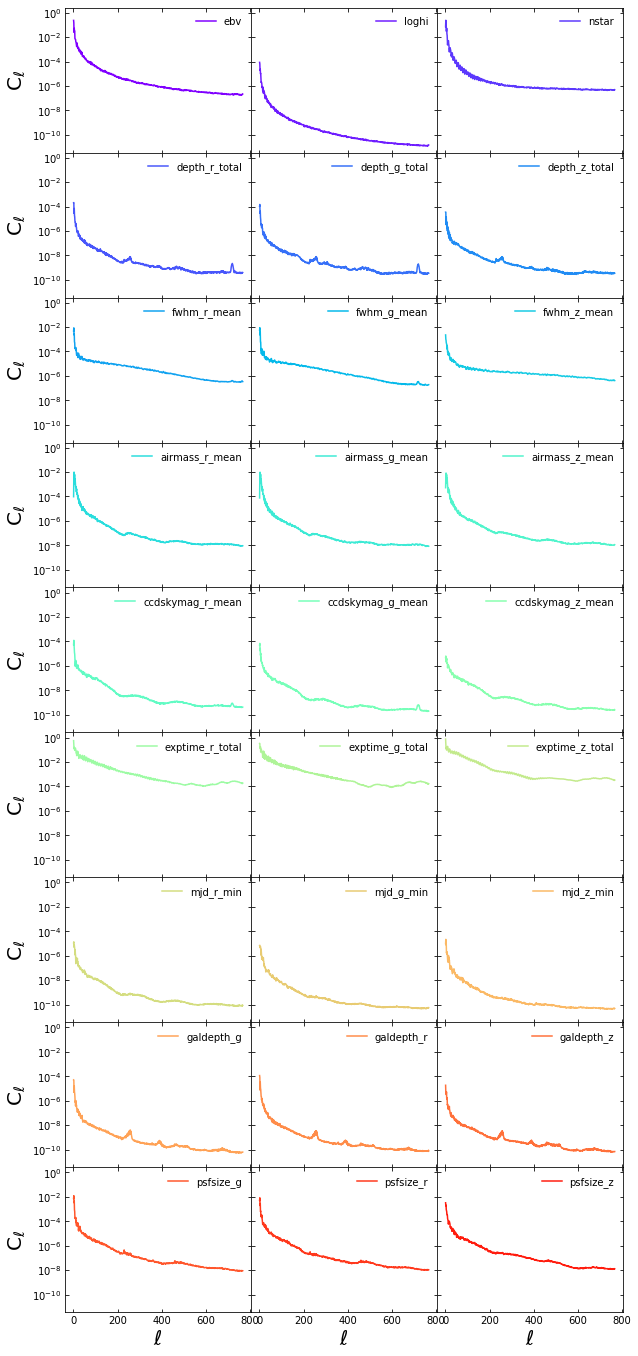

In [239]:
fig, ax = plt.subplots(ncols=3, nrows=9, figsize=(10, 24), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)
ax = ax.flatten()
for i, cl_i in enumerate(cl_templates):
    ax[i].plot(cl_i['l'][1:], cl_i['cl'][1:], label=dr8_cols[i], 
             color=plt.cm.rainbow(i/len(dr8_cols)),)
    ax[i].set_yscale('log')
    ax[i].legend(frameon=False)
    ax[i].tick_params(direction='in', which='both', axis='both', right=True, top=True)
    if (i%3)==0:ax[i].set_ylabel(r'C$_{\ell}$', fontsize=20)
    if i > 23:ax[i].set_xlabel(r'$\ell$', fontsize=20)
        
fig.savefig('cl_templates.png', dpi=300, bbox_inches='tight')

# plt.yscale('log')
# leg = plt.legend(bbox_to_anchor=(1.1, 1.1), ncol=2)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(3.0)
#     legobj.set_alpha(1.0)

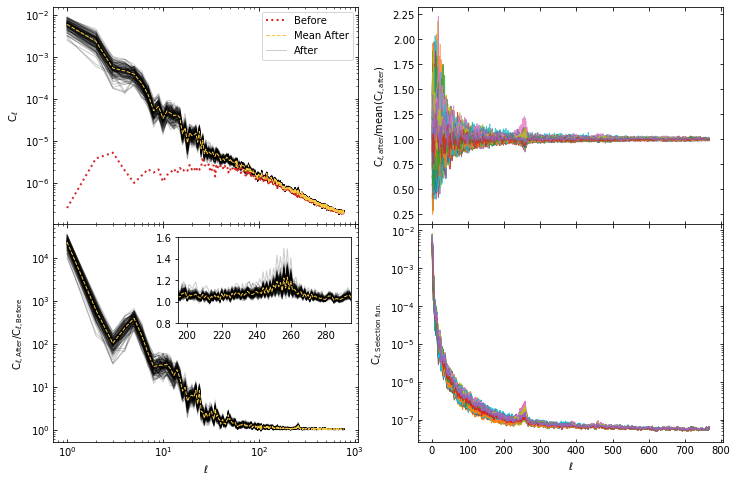

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex='col')
fig.subplots_adjust(hspace=0.0)
ax = ax.flatten()


# plot Cl before and after
ell = np.arange(1, 768)
cl_aft_m = np.mean(cl_aft, axis=0)

ax[0].plot(ell, cl_bef['cl'][1:], 'C3:', lw=2)
ax[0].plot(ell, cl_aft_m[1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[0].plot(ell, cl_aft_[1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[0].legend(['Before', 'Mean After', 'After'])
ax[0].set(yscale='log', xscale='log', ylabel=r'C$_{\ell}$')


# ratio after to before
ax[2].plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[2].plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[2].set(yscale='log', xlabel=r'$\ell$', ylabel=r'C$_{\ell, \rm After}$/C$_{\ell, \rm Before}$')
ax2 = fig.add_axes([0.27, 0.33, 0.2, 0.15])
ax2.plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax2.plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax2.set(xlim=(195, 295), ylim=(0.8, 1.6))


# ratio after to mean after
for cl_aft_ in cl_aft:
    ax[1].plot(ell, cl_aft_[1:]/cl_aft_m[1:], '-', alpha=0.8, lw=1, zorder=-1)
    
ax[1].set(ylabel=r'C$_{\ell, \rm after}$/mean(C$_{\ell, \rm after}$)')

# selection function
for cl_sf_ in cl_sf:
    ax[3].plot(ell, cl_sf_[1:], lw=1, zorder=-1)

ax[3].set(xlabel=r'$\ell$', ylabel=r'C$_{\ell,\rm Selection~fun.}$', yscale='log')

for axi in ax:
    axi.tick_params(direction='in', axis='both', which='both', right=True, top=True)

fig.savefig('cl_jk.png', dpi=300, bbox_inches='tight')

# random initialization

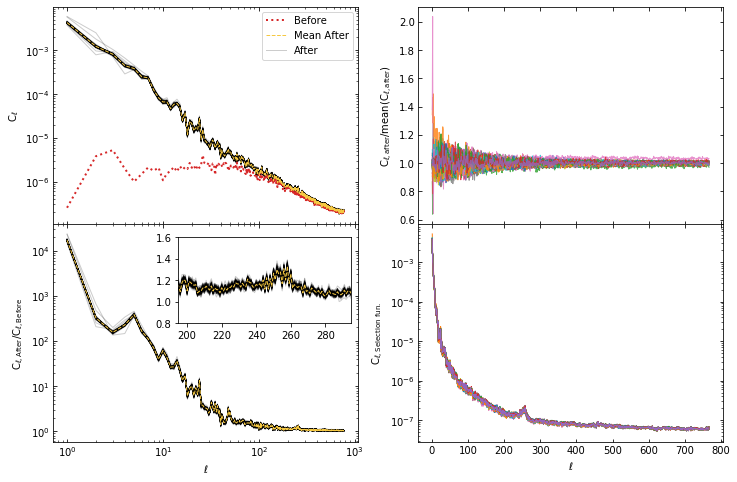

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex='col')
fig.subplots_adjust(hspace=0.0)
ax = ax.flatten()


# plot Cl before and after
ell = np.arange(1, 768)
cl_aft_m = np.mean(cl_aft, axis=0)

ax[0].plot(ell, cl_bef['cl'][1:], 'C3:', lw=2)
ax[0].plot(ell, cl_aft_m[1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[0].plot(ell, cl_aft_[1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[0].legend(['Before', 'Mean After', 'After'])
ax[0].set(yscale='log', xscale='log', ylabel=r'C$_{\ell}$')


# ratio after to before
ax[2].plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[2].plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[2].set(yscale='log', xlabel=r'$\ell$', ylabel=r'C$_{\ell, \rm After}$/C$_{\ell, \rm Before}$')
ax2 = fig.add_axes([0.27, 0.33, 0.2, 0.15])
ax2.plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax2.plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax2.set(xlim=(195, 295), ylim=(0.8, 1.6))


# ratio after to mean after
for cl_aft_ in cl_aft:
    ax[1].plot(ell, cl_aft_[1:]/cl_aft_m[1:], '-', alpha=0.8, lw=1, zorder=-1)
    
ax[1].set(ylabel=r'C$_{\ell, \rm after}$/mean(C$_{\ell, \rm after}$)')

# selection function
for cl_sf_ in cl_sf:
    ax[3].plot(ell, cl_sf_[1:], lw=1, zorder=-1)

ax[3].set(xlabel=r'$\ell$', ylabel=r'C$_{\ell,\rm Selection~fun.}$', yscale='log')

for axi in ax:
    axi.tick_params(direction='in', axis='both', which='both', right=True, top=True)

fig.savefig('cl_randinit.png', dpi=300, bbox_inches='tight')

# Snapshot

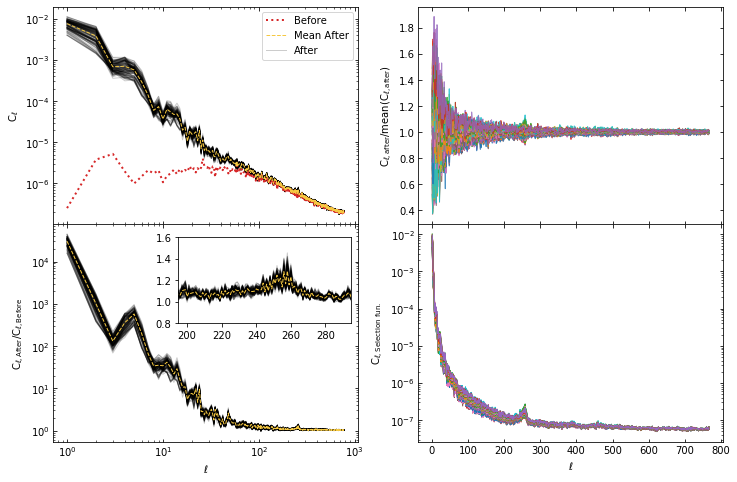

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex='col')
fig.subplots_adjust(hspace=0.0)
ax = ax.flatten()


# plot Cl before and after
ell = np.arange(1, 768)
cl_aft_m = np.mean(cl_aft, axis=0)

ax[0].plot(ell, cl_bef['cl'][1:], 'C3:', lw=2)
ax[0].plot(ell, cl_aft_m[1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[0].plot(ell, cl_aft_[1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[0].legend(['Before', 'Mean After', 'After'])
ax[0].set(yscale='log', xscale='log', ylabel=r'C$_{\ell}$')


# ratio after to before
ax[2].plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax[2].plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax[2].set(yscale='log', xlabel=r'$\ell$', ylabel=r'C$_{\ell, \rm After}$/C$_{\ell, \rm Before}$')
ax2 = fig.add_axes([0.27, 0.33, 0.2, 0.15])
ax2.plot(ell, cl_aft_m[1:]/cl_bef['cl'][1:], ls='--', color='#f5c842', lw=1)
for cl_aft_ in cl_aft:
    ax2.plot(ell, cl_aft_[1:]/cl_bef['cl'][1:], 'k-', alpha=0.2, lw=1, zorder=-1)
ax2.set(xlim=(195, 295), ylim=(0.8, 1.6))


# ratio after to mean after
for cl_aft_ in cl_aft:
    ax[1].plot(ell, cl_aft_[1:]/cl_aft_m[1:], '-', alpha=0.8, lw=1, zorder=-1)
    
ax[1].set(ylabel=r'C$_{\ell, \rm after}$/mean(C$_{\ell, \rm after}$)')

# selection function
for cl_sf_ in cl_sf:
    ax[3].plot(ell, cl_sf_[1:], lw=1, zorder=-1)

ax[3].set(xlabel=r'$\ell$', ylabel=r'C$_{\ell,\rm Selection~fun.}$', yscale='log')

for axi in ax:
    axi.tick_params(direction='in', axis='both', which='both', right=True, top=True)

fig.savefig('cl_snapshot.png', dpi=300, bbox_inches='tight')

In [3]:
#gensys = GenSys('/home/mehdi/data/tanveer/elg_mse/nn-weights.fits')


# of selection functions:  (302503, 125)


.............................................................................................................................

In [11]:
# linear
# gensys2 = GenSys('/home/mehdi/data/tanveer/elg_lin/nn-weights.fits')
# af = AnaFast()

# results2 = {}

# #results['before'] = af(delta_clean, ran, mask)
# delta_ix = gensys2(0, dat, ran, mask, delta_clean)
# results2[f'after_lin'] = af(delta_ix, ran, mask)

In [41]:
from lssutils.dataviz import mollview, mycolor

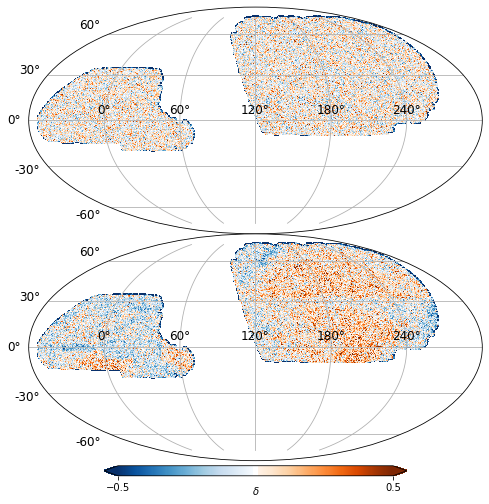

In [42]:
unit = r'$\delta$'
vmin = -0.5
vmax = 0.5

fig = plt.figure(figsize=(7, 7))
# matplotlib is doing the mollveide projection
ax  = fig.add_subplot(211, projection='mollweide')
ax1 = fig.add_subplot(212, projection='mollweide')
spacing = 0.05
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0, wspace=0.0)


mollview(delta_clean, vmin, vmax, unit, figax=[fig, ax], cmap=mycolor())
mollview(delta_ix, vmin, vmax, unit, figax=[fig, ax1], cmap=mycolor(), colorbar=True)
fig.savefig('delta_before_after_delta.png', dpi=300, bbox_inches='tight')

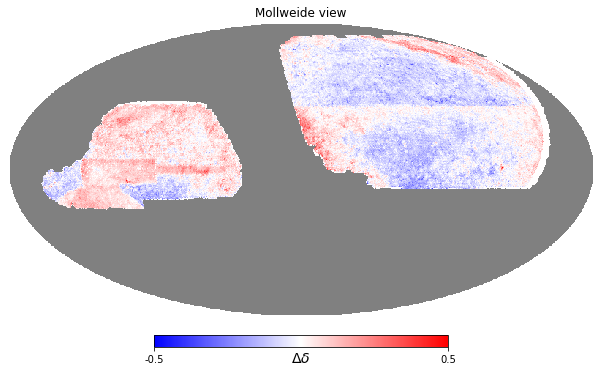

In [48]:
hp.mollview(delta_clean - delta_ix, min=-0.5, max=0.5, 
            cmap=plt.cm.bwr, unit=r'$\Delta \delta$', rot=+270)

In [2]:
dat_ = ft.read('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_10.fits')    
dat = hpixsum(256, dat_['RA'], dat_['DEC'])*1.0
ran = hp.read_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits', 
                  verbose=False, dtype=np.float64)*1.0
mask = (ran > 0)
delta_clean = make_overdensity(dat, ran, mask) # clean delta

In [3]:
hp.write_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_10_delta.hp256.fits', delta_clean)